In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from architecture.MLP import FCNet
from utils import normalize_weights, get_data, evaluate
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# turn off warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# choose width
width = 512

In [3]:
# choose two random indices from 0 to 49
idx1 = np.random.randint(0, 50)
idx2 = np.random.randint(0, 50)
while idx1 == idx2:
    idx2 = np.random.randint(0, 50)

In [4]:
# define and load the models
model1 = FCNet(2, width, 1, 1)
model2 = FCNet(2, width, 1, 1)

model1.load_state_dict(torch.load(f"models/sigmoid/moons/model_s512_w{width}_d1_{idx1}.pth"))
model2.load_state_dict(torch.load(f"models/sigmoid/moons/model_s512_w{width}_d1_{idx2}.pth"))

# plot the decision boundaries of model1, model2 and the average model
average_model = FCNet(2, width, 1, 1)
average_state_dict = OrderedDict()
for key in model1.state_dict():
    average_state_dict[key] = (model1.state_dict()[key] + model2.state_dict()[key]) / 2

average_model.load_state_dict(average_state_dict)

<All keys matched successfully>

In [5]:
train_loader, test_loader = get_data("moons", 512)

# choose 5 indices in the range of [0, width)
indices = np.random.choice(width, 5, replace=False)

In [6]:
def plotter(model1, model2, average_model, width):
    # plot the decision boundaries of model1, model2 and the average model in 1*3 subplots

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].set_title("model1")
    axs[1].set_title("model2")
    axs[2].set_title("average model")

    for i, model in enumerate([model1, model2, average_model]):
        model.eval().to(device)
        x1 = np.linspace(-3, 3, 100)
        x2 = np.linspace(-3, 3, 100)
        X1, X2 = np.meshgrid(x1, x2)
        X = np.concatenate([X1.reshape(-1, 1), X2.reshape(-1, 1)], axis=1)
        X = torch.from_numpy(X).float().to(device)
        y = model(X).detach().cpu().numpy().reshape(100, 100)
        # apply sigmoid
        y = 1 / (1 + np.exp(-y))

        # plot the lines corresponding to each hidden node
        for j in range(width):
            w = model.layers[0].weight[j].detach().cpu().numpy()
            b = model.layers[0].bias[j].detach().cpu().numpy()
            z = -w[0] / w[1] * x1 - b / w[1]
            if j in indices:
                axs[i].plot(x1, z, c=f"C{j}", linestyle="--", linewidth=2)
            else:
                axs[i].plot(x1, z, c=f"C{j}", linestyle="--", linewidth=1, alpha=0.1)
        axs[i].contourf(x1, x2, y, 10, cmap="pink", alpha=0.8)
        # display countour lines
        axs[i].contour(x1, x2, y, 10, colors="k", linewidths=0.5, alpha=0.2)
        # highlight line at 0.5
        axs[i].contour(x1, x2, y, levels=[0.5], colors="k", linewidths=2)
        axs[i].set_aspect("equal")
        axs[i].set_xlim(-3, 3)
        axs[i].set_ylim(-3, 3)

        # plot the training data
        for x_, y_ in train_loader:
            x_ = x_.numpy()
            y_ = y_.numpy()
            axs[i].scatter(x_[y_ == 0, 0], x_[y_ == 0, 1], c="b", s=10)
            axs[i].scatter(x_[y_ == 1, 0], x_[y_ == 1, 1], c="r", s=10)
    plt.show()

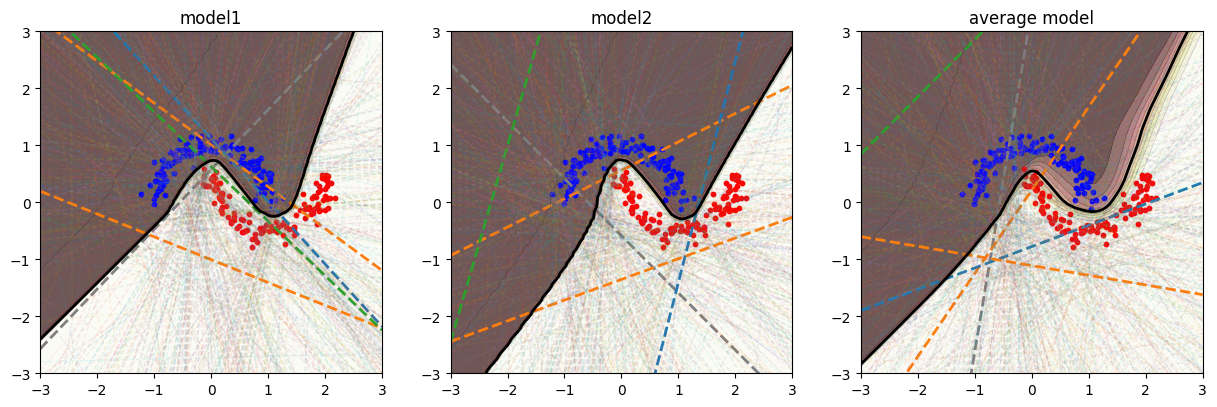

In [7]:
plotter(model1, model2, average_model, width)

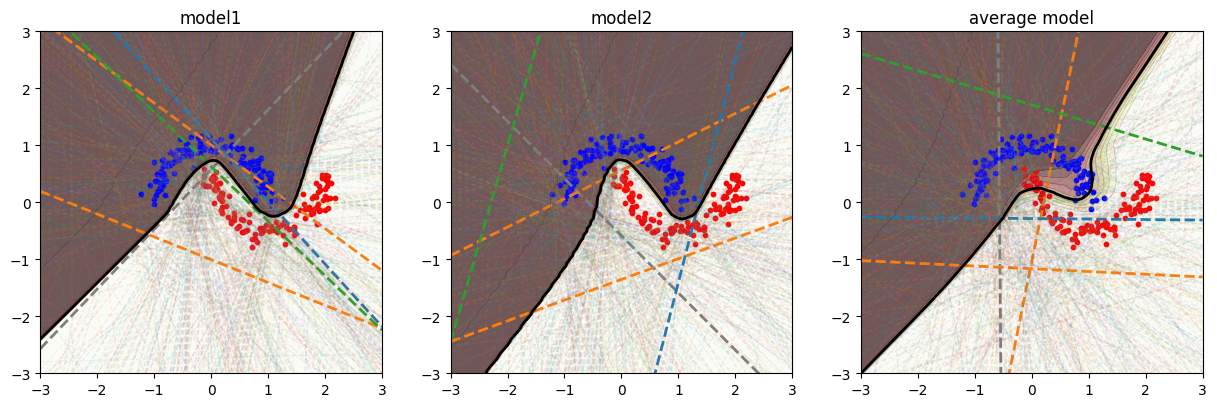

In [8]:
# normalize the weights
model1 = normalize_weights(model1)
model2 = normalize_weights(model2)

average_model = FCNet(2, width, 1, 1)
average_state_dict = OrderedDict()
for key in model1.state_dict():
    average_state_dict[key] = (model1.state_dict()[key] + model2.state_dict()[key]) / 2

average_model.load_state_dict(average_state_dict)

# plot the decision boundaries of normalized model1, model2 and the average model
plotter(model1, model2, average_model, width)

In [9]:
# average all the models from 0 to 49
average_model = FCNet(2, width, 1, 1).to(device)
average_state_dict = OrderedDict()
for key in model1.state_dict():
    average_state_dict[key] = torch.zeros_like(model1.state_dict()[key])

for i in range(50):
    model = FCNet(2, width, 1, 1).to(device)
    model.load_state_dict(torch.load(f"models/sigmoid/moons/model_s512_w{width}_d1_{i}.pth"))
    # model = normalize_weights(model)
    for key in model.state_dict():
        average_state_dict[key] += model.state_dict()[key]

for key in average_state_dict:
    average_state_dict[key] /= 50

average_model.load_state_dict(average_state_dict)

<All keys matched successfully>

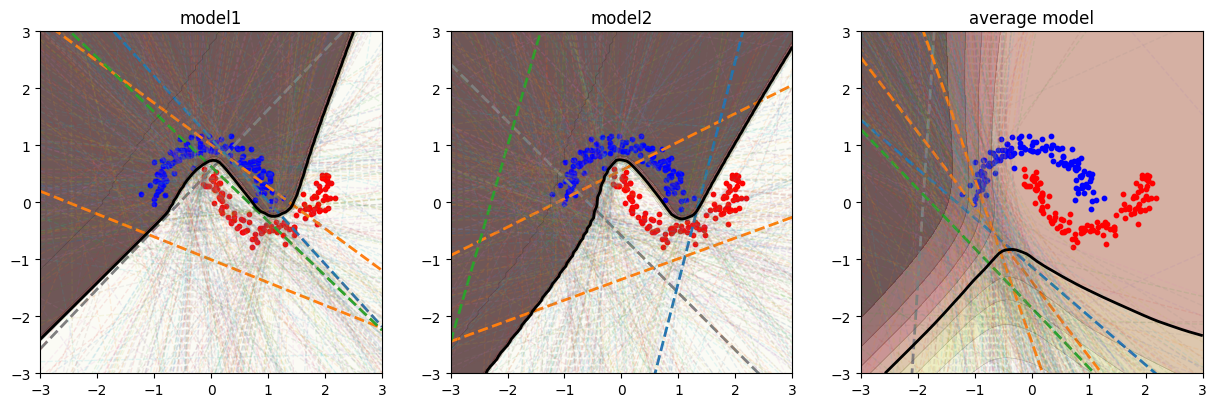

In [10]:
# plot the decision boundaries of normalized model1, model2 and the average model
plotter(model1, model2, average_model, width)

averaging all models yields poor results, so what models should we average? Low loss models? Similar models?

WHAT IS NOT WORKING
- trying weight averaging using training loss
- trying averaging only low loss models

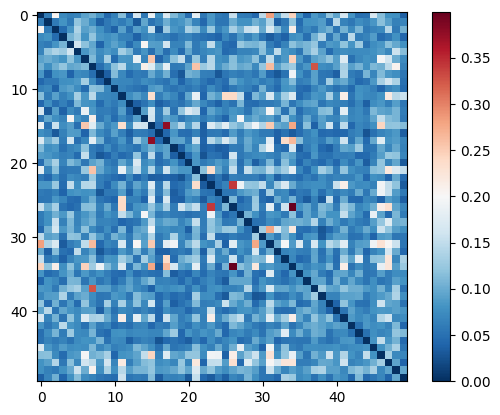

In [11]:
# finding similar models
choice = "" # "max" or ""

naive_max_barriers = np.load(f"logs/sigmoid/moons/naive{choice}_barriers_train_s512_w{width}_d1.npy")

# visualize the naive max barriers using imshow
plt.imshow(naive_max_barriers, cmap="RdBu_r")
plt.colorbar()
plt.show()

bias on the final layer?